# Preramble

One of the questions that was asked was "Where can I get data to play with this on my own?" The Enron header file is included but here are some other ideas:
- [Hillary Clinton's email](https://www.kaggle.com/kaggle/hillary-clinton-emails)
- [Shopping Data](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/data)
- [IMDB Data](https://www.imdb.com/interfaces/)
- [Flight Data](https://openflights.org/data.html) - not current but still very cool.

The "[Specialized Tools](http://127.0.0.1:8888/notebooks/graphs.ipynb#Specialized-tools) will also likely have links to datasets. For instance, [NetworkX](https://networkx.org/) has some small networks built in, like [Karate Club](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.karate_club_graph.html). Great for testing.

[This notebook](https://github.com/keithpjolley/python_graph_demo) is available on GitHub <s>and as a static web-page (disconnected from Python) [here](https://www.jamulheavyindustries.com/presentations/pythonsd_graph/).</s>

In [1]:
import colorsys
import heapq
import json
import typing
from copy import deepcopy
from operator import add

# plotly changed something behind the scenes and broke this notebook.
# It doesn't really matter because it was only used as an example of
# what looks bad.
# plotly -> chart_studio.
# import chart_studio.plotly as py
import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
# See note above about plotly.
# import plotly.graph_objs as go
import scipy
from IPython.display import HTML, display
from matrepr import mprint

%matplotlib inline

min_s, max_s = 10, 100  # for plotly - moon units?
min_r, max_r = 6, 25  # for d3 - node radius in pixels


def color(object_number: int, total_objects: int) -> str:
    """! Use colorsys to find an RGB color.
    Returns a color on the edge of the hsv color wheel, starting at the top of the
    color wheel and rotating c*360/(total_objects+1) degrees where "c" is index of
    this particular object.

    @param  object_number  Index of this object.
    @param  total_objects  Number of objects.
    @return  RGB color (A string like #ff00ff).
    """
    return "#" + "".join(
        f"{int(255 * x):02x}"
        for x in colorsys.hsv_to_rgb(object_number / (total_objects + 1), 1, 1)
    )


def plt2x2(g: nx.classes.graph.Graph, picture: str) -> plt.figure:
    """! Plots graph g using the networkx kamada_kawai algorithm. Also plots
    `picture` next to it.

    @param g  networkx plot (with attributes `color` and `radius` set.
    @param  picture  A picture to plot next to G.
    @return  a figure suitable for framing.
    """
    fig, (ax1, ax2) = plt.subplots(
        1, 2, num=None, figsize=(14, 8), dpi=72, facecolor="w", edgecolor="k"
    )
    _ = nx.draw_kamada_kawai(
        g,
        ax=ax1,
        node_color=list(nx.get_node_attributes(G, "color").values()),
        node_size=[4 * s for s in nx.get_node_attributes(G, "size").values()],
    )
    pic = plt.imread(picture)
    ax2.imshow(pic)
    ax2.set_title("What if this is as good as it gets?")
    return fig


def inject(*st, file=None, code_type=None) -> None:
    """! The native `%javascript` and `javascript()` functions don't quite
    work like I expect them to. This is more predictable in my world.
    Originally just for javascript but extended to css and html.
    https://stackoverflow.com/a/53779330/2624770
    """
    if len(st) == 1 and file is None:
        str_to_inject = st[0]
    elif len(st) == 0 and file is not None:
        str_to_inject = open(file).read()
    else:
        raise ValueError("Pass either a string or file=.")
    # If the code to be injected is javascript or css then
    # it needs to be wrapped. If none given raw dog it.
    if code_type in ["javascript", "js"]:
        str_to_inject = "<script>" + str_to_inject + "</script>"
    elif code_type in ["style", "css"]:
        str_to_inject = "<style>" + str_to_inject + "</style>"
    display(HTML(str_to_inject))


def style_graph(g: graphviz.graphs.Digraph) -> None:
    """! Saves clutter later."""
    g.attr(rankdir="LR")
    g.attr(bgcolor="#00000000")
    g.body.append(
        'node[style=invis]\n0->1->2->3->4[style=invis]\nnode[style=""]\n'
    )
    g.attr("edge", color="red")
    g.attr("node", color="grey")
    g.attr("node", shape="oval")
    g.attr("node", style="filled")
    g.attr("node", fillcolor="white")
    g.body.append("{rank=same; 0; Alice;}")
    g.body.append("{rank=same; 2; Carol; Bob; Doug;}")


def minmax_scale(
    x: list[float], feature_range: tuple[int, int]
) -> np.ndarray[typing.Any, np.dtypes.Float64DType]:
    """! This more or less duplicates the sklearn minmax_scale() function.
    This saves having to import the sklearn module for just one function.
    I haven't benchmarked performance but for this use it probably doesn't
    matter if it's somewhat slower. It also doesn't handle corner cases or
    do error checking (like max-min == 0).
    """
    fr_min, fr_max = feature_range
    x = np.array(x)
    x_min = x.min()
    x_std = (x - x_min) / (x.max() - x_min)
    x_scaled = x_std * (fr_max - fr_min) + fr_min
    return x_scaled

/private/var/folders/gf/xx1d59ss1v7fcrrg8bzmhgmm0000gn/T/tmp.Bhn6M5zeB9/lib/python3.13/site-packages/chart_studio/tools.py:290: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if share_key is "":


In [2]:
inject(file="include/js/d3@7", code_type="js")
inject(file="include/js/forcedirected.js", code_type="js")
# Script for d3 plot.
inject(file="include/js/doodle.js", code_type="js");

# Python & Graphs
### Keith P Jolley

# What's This Talk About?

### 1. What is a graph?
### 2. What can graphs be used for?
### 3. A couple things to keep in mind when working with graphs.
### 4. How to create graph in a handful of different python packages.
### 5. A simple analysis using `networkx`.
### 6. Visualizing the graphs.

## Keith P Jolley

### Experience:
- DevOps, ZaiNar
- IT/DevOps, Light, acquired by Blue River (John Deere)
- Technical Account Manager, NetApp
- Senior Director, IT - Qualcomm
- Analyst, Naval Health Research Center

### Education:
- BS Aerospace Engineering, 1992, SDSU
- MS Computational Science, 2013, SDSU
- ~MS Data Analytics, ~To be completed 2019, Georgia Tech~

# What's a Graph or Network?

A visual or mathematical representation of **Nodes** and **Edges** based on how nodes are **connected**.

**Nodes**, also called **vertices**, are the "things" in the network.

**Edges**, also called **arcs**, are the "connections" in the network. They represent the relationship between nodes.

Edges may have **weight**. An edge with weight shows the relative magnitude of the connectivity between two nodes. Edges can have multiple parameters or attributes.

Edges may have **direction**.

Some networks may have edges with the same "source" and "target."

Graph and network are two words for the same thing:
[Wolfram Alpha Oct 2024](https://www.wolfram.com/language/elementary-introduction/2nd-ed/21-graphs-and-networks.html).

# Types of Graphs

- A network is either "directed" or "undirected."
  - A directed graph implies a direction of edges.
  - Friends on a social network would be undirected because if A is a friend with B then B is also a friend with A.
  - Travel times between cities A to B maybe different than B to A and call for a directed graph.
- Networks are "weighted" or "unweighted."
  - In a "weighted" graph the edges have a numeric value, usually called "weight."
  - The total number of bytes sent from A to B could be a weight you are interested in.
  - In an unweighted graph an edge between nodes either exist or doesn't.

# Graph Examples

- Social Network (LinkedIn: People, Companies, Jobs are nodes, edges are the connections)
- Email Networks (Google Mail: People, Emails are nodes, sending/receiving emails are the edges)
- Websites (Google: Pages are nodes, hyperlinks are the edges)
- Roads (Waze: Intersections are vertices, roads are the edges, "traffic" is the weight)
- [Oracle of Bacon](https://oracleofbacon.org/movielinks.php) (Actors are the nodes, "credits" are the edges)

# You Should Know

## Graphs become large quickly

Worst case: $N^2$ where N is the number of nodes.

A social network of all 2.1M Walmart employees is big.

The graph of all ~3B Facebook users is really big.

Google's graph "every page google knows about" is huge.

If your graph has tens of millions or billions of nodes then `numpy` or `networkx`, may not be a good fit.

# You Should Know...

## Specialized tools

There are tools that are made for graphs that may be more appropriate as your graphs increase in size. For example:

- [Graphviz](https://graphviz.org/about/) - Simple graph plotter (dot). Examples inline.
- [Neo4j](https://neo4j.com/) - Graph database
- [Gephi](https://gephi.org/)
- [Cytoscape](https://cytoscape.org/)
- [R](https://www.r-project.org) and [igraph](https://r.igraph.org) - Fine for smallish graphs
- [Linkurious](https://linkurio.us/) - Commercial solution

FYI: Relational databases are a terrible choice for managing relationships!

# You Should Know...

## Visualization...

Visualizing large graphs is hard. There are no good network visualization tools in Python as of late 2018 (still true in 2024). From the [authors](https://networkx.github.io/documentation/latest/reference/drawing.html) of `networkx`:

> ## Drawing
> In the future, graph visualization functionality may be removed from NetworkX or only available as an add-on package.
>
> Proper graph visualization is hard, and we highly recommend that people visualize their graphs with tools dedicated to that task.
>

# Visualization...

Hairball. Please don't do this.
![terrible graph visualization that looks like a hairball](include/images/hairball.png)


<sub><sup>This is the best I could do using one of the tools listed prior.</sup></sub>

# Let's Build A (directed, weighted) Network Already!

## 0. Alice sends an email

*Edge Notation:* Alice -> (Bob, Carol, Dan)

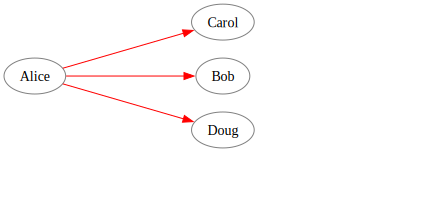

In [3]:
g = graphviz.Digraph()
style_graph(g)
# Add edges from Alice to Bob, Carol, and Doug.
g.edges(("Alice", n) for n in ["Bob", "Carol", "Doug"])
display(g)

**Matrix Notation:**

Read this as "rows" are the senders while "columns" are the receivers.

<div class="box matrix">
$\left[ \begin{array}{cccc}
      & A & B & C & D & E & F \\
    A & {\color{grey}0} & {\color{red}1}  & {\color{red}1}  & {\color{red}1}  & {\color{grey}0} & {\color{grey}0} \\
    B & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    C & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    D & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    E & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    F & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
  \end{array}
\right] $
</div>

In [4]:
# This is the equivalent numpy array:
Gnp = np.array(
    [
        [0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]
)

### 1. Carol replies all.

*Edge Notatation:* Carol -> (Alice, Bob, Dan)  

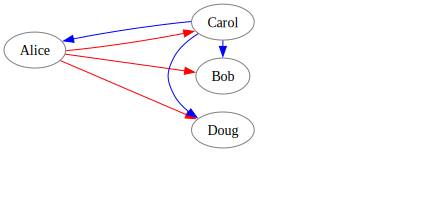

In [5]:
# Add edges from Alice to Bob, Carol, and Doug.
g1 = deepcopy(g)
[g1.edge("Carol", node, color="blue") for node in ["Alice", "Bob", "Doug"]]
display(g1)

*Matrix Notation:*  

<div class="box matrix">
$\left[ \begin{array}{cccc}
      & A & B & C & D & E & F \\
    A & {\color{grey}0} & {\color{red}1}  & {\color{red}1}  & {\color{red}1}  & {\color{grey}0} & {\color{grey}0} \\
    B & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    C & {\color{blue} 1} & {\color{blue} 1} & {\color{grey}0} & {\color{blue} 1} & {\color{grey}0} & {\color{grey}0} \\
    D & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    E & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    F & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
  \end{array}
\right] $
</div>

In [6]:
# This is the equivalent numpy array:
Gnp += np.array(
    [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]
)

### 2. Carol sends another email

*Edge Notation:* Carol -> (Erin, Frank)  

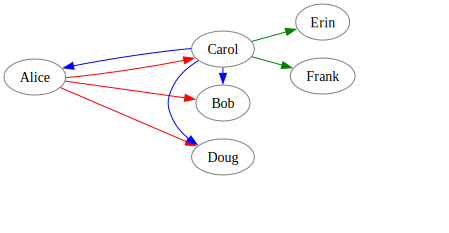

In [7]:
# Note that more can be done to make the plots look nicer but that's
# outside the scope of this notebook.
g2 = deepcopy(g1)
targets = ["Erin", "Frank"]
[g2.edge("Carol", node, color="green") for node in targets]
display(g2)

**Matrix Notation:**

<div class="box matrix">
$\left[ \begin{array}{cccc}
    A & {\color{grey}0} & {\color{red}1}  & {\color{red}1}  & {\color{red}1}  & {\color{grey}0} & {\color{grey}0} \\
    B & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    C & {\color{blue}1} & {\color{blue}1} & {\color{grey}0} & {\color{blue}1} & {\color{green}1} & {\color{green}1} \\
    D & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    E & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
    F & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} & {\color{grey}0} \\
  \end{array}
\right] $
</div>

In [8]:
# This is the equivalent numpy array:
Gnp += np.array(
    [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]
)

## With Sparse Matrix
### 0. Alice sends an email

*Edge notation:* Alice -> (Bob, Carol, Dan)

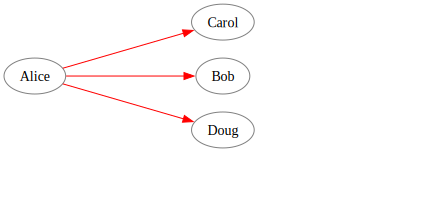

In [9]:
display(g)

In [10]:
i2n = ["Alice", "Bob", "Carol", "Dan", "Erin", "Frank"]
n2i = {n: i for i, n in enumerate(i2n)}
weight = [1, 1, 1]
frm = [n2i["Alice"], n2i["Alice"], n2i["Alice"]]
to_ = [n2i["Bob"], n2i["Carol"], n2i["Dan"]]
Gsm = scipy.sparse.coo_matrix((weight, (frm, to_)), shape=(6, 6))
mprint(Gsm, title=None, indices=False)

┌               ┐
│   1  1  1     │
│               │
│               │
│               │
│               │
│               │
└               ┘


### 1. Carol replies all

*Edge Notatation:* Carol -> (Alice, Bob, Dan)  

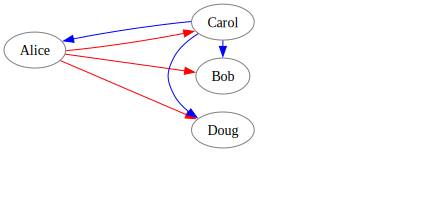

In [11]:
display(g1)

In [12]:
Gsm += scipy.sparse.coo_matrix(
    ([1, 1, 1], ([2, 2, 2], [0, 1, 3])), shape=(6, 6)
)  # no broadcasting w/ sparse matrix
mprint(Gsm, title=None, indices=False)

┌                ┐
│    1  1  1     │
│                │
│ 1  1     1     │
│                │
│                │
│                │
└                ┘


### 2. Carol sends another email

*Edge Notation:* Carol -> (Erin, Frank)

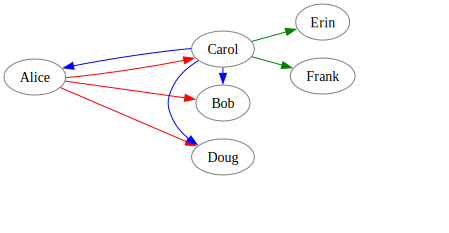

In [13]:
display(g2)

In [14]:
Gsm += scipy.sparse.coo_matrix(([1, 1], ([2, 2], [4, 5])), shape=(6, 6))
mprint(Gsm, title=None, indices=False)

┌                  ┐
│    1  1  1       │
│                  │
│ 1  1     1  1  1 │
│                  │
│                  │
│                  │
└                  ┘


# With networkx

In [15]:
Gnx = nx.DiGraph()
# Alice -> Bob, Carol, Dan
Gnx.add_edge("Alice", "Bob", weight=1)
Gnx.add_edge("Alice", "Carol", weight=1)
Gnx.add_edge("Alice", "Dan", weight=1)
# Carol -> Alice, Bob, Dan
Gnx.add_edge("Carol", "Alice", weight=1)
Gnx.add_edge("Carol", "Bob", weight=1)
Gnx.add_edge("Carol", "Dan", weight=1)
# Carol -> Erin, Frank
Gnx.add_edge("Carol", "Erin", weight=1)
Gnx.add_edge("Carol", "Frank", weight=1)

display(Gnx.edges(data=True))

OutEdgeDataView([('Alice', 'Bob', {'weight': 1}), ('Alice', 'Carol', {'weight': 1}), ('Alice', 'Dan', {'weight': 1}), ('Carol', 'Alice', {'weight': 1}), ('Carol', 'Bob', {'weight': 1}), ('Carol', 'Dan', {'weight': 1}), ('Carol', 'Erin', {'weight': 1}), ('Carol', 'Frank', {'weight': 1})])

# Equivalence

In [16]:
print("Sparse Matrix:")
print(Gsm)
display(Gsm.toarray())

Sparse Matrix:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8 stored elements and shape (6, 6)>
  Coords	Values
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (2, 0)	1
  (2, 1)	1
  (2, 3)	1
  (2, 4)	1
  (2, 5)	1


array([[0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Equivalence (cont...)

In [17]:
GnpEqGsm = (Gnp == Gsm.toarray()).all()
GnpEqGnx = (Gnp == np.int64(nx.to_numpy_array(Gnx))).all()
print(f"Is the numpy graph equal to the sparse matrix graph: {GnpEqGsm}")
print(f"Is the numpy graph equal to the networkx graph: {GnpEqGnx}")

Is the numpy graph equal to the sparse matrix graph: True
Is the numpy graph equal to the networkx graph: True


## The point is...
There are different ways of approaching graph problems. Choose what works best for your situation.

# Show me something practical!
## Hands-on with `networkx`

# Enron Email Database
- Available online.
- Has complete text and headers of 3715057 emails.
- I've parsed the database into a csv file.
- Also dumped into `elasticsearch` but not used for this demo.

In [18]:
# NOTE: I compressed this csv file to be nice w/ github. You may want to
# uncompress it for better performance at the cost of ~200MB of disk space.
# (Or not using a csv at all!)
df = pd.read_csv(
    "./data/enronmails.csv.bz2", sep="\t"
)  # there are better ways of doing this!
print(
    f"total number of nodes: {len(pd.unique(df[['to', 'from']].values.ravel('F')))}"
)
print(f"total number of edges: {df.shape[0]}")
print("sample data:")
display(df.head(n=5))

total number of nodes: 89993
total number of edges: 3712732
sample data:


,from,to,mbox,subject,size
0,rob_tom,calxa@aol.com,allen-p,re: history of lime and cement,950801820
1,rob_tom,strawbale@crest.org,allen-p,re: history of lime and cement,950801820
2,matt,strawbale@crest.org,allen-p,re: concrete stain,947291340
3,billc,strawbale@crest.org,allen-p,re: newsgroups,950175960
4,grensheltr,mccormick@elkus-manfredi.com,allen-p,re: concrete stain,947107440


## Create a directed, weighted Graph
- **to:/from:** will be the nodes.
- An edge represents an **email** was received.
- ~40k **self loops**, e.g. (alice -> alice). These would show up on a matrix diagonal.
- Create a 'weight' of `1` for each email received.
- A handful of nodes do all the work.

In [19]:
# df_all is the complete network. Create edge weights in pandas.
df_all = (
    df.groupby(["from", "to"], as_index=False)
    .size()
    .reset_index()
    .rename(columns={"size": "weight"})
)
G = nx.from_pandas_edgelist(df_all, "to", "from", ["weight"])
del df_all
# Multiple ways of finding the most 'connected' nodes,
# like 'pagerank'.  The different algorithms are out of
# scope of this presentation.  They are presentation unto
# themselves.
pr = nx.pagerank(G, weight="weight").values()
print("Pagerank summary statistics:")
display(pd.Series(pr).describe())
print(f"\nSum of all pagerank values: {sum(pr):0.7f}")

Pagerank summary statistics:


count    89992.000000
mean         0.000011
std          0.000069
min          0.000002
25%          0.000002
50%          0.000004
75%          0.000006
max          0.006580
dtype: float64


Sum of all pagerank values: 1.0000000


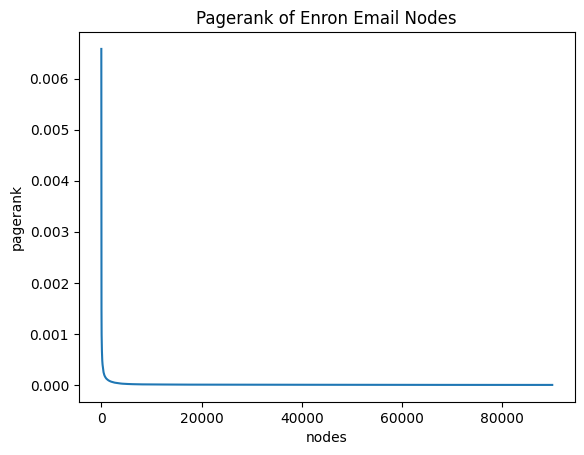

In [20]:
plt.plot(sorted(pr, key=lambda v: -v))
plt.title("Pagerank of Enron Email Nodes")
plt.ylabel("pagerank")
plt.xlabel("nodes");

The point is: typically only a few nodes do all the heavy lifting and the rest take up space.

# Find the graph of something interesting
- Search for "California" in the *'subject:'* line.  
> "For most popular subjects, a simple text matching search that is restricted to web page titles performs admirably when PageRank prioritizes the results."  
> – *Sergey Brin and Lawrence Page*, Stanford University
- Warning - lots of code about to come at you.
- Remember - much of the heavy lifting is done by only a few nodes
- Interesting things happen when you combine graphs/searches.
- Plot with `networkx`.

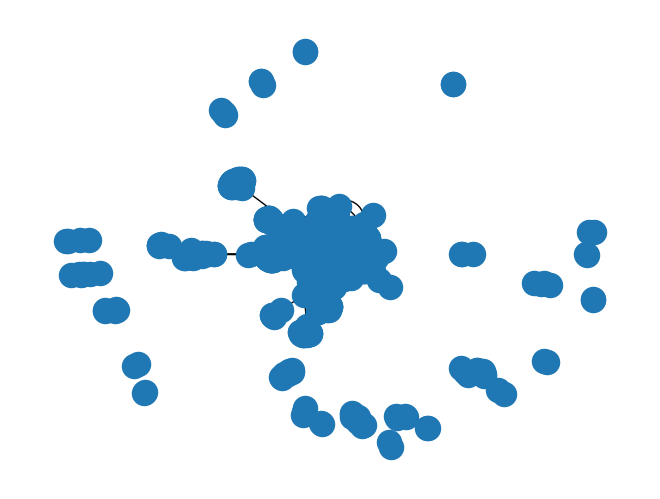

In [21]:
# Create a df of just the 'california' rows (elasticsearch is your friend!)
df_cal = df[df.subject.str.contains(r"california", case=False)]
df_cal = (
    df_cal.groupby(["from", "to"], as_index=False)
    .size()
    .reset_index()
    .rename(columns={"size": "weight"})
)
G = nx.from_pandas_edgelist(df_cal, "to", "from", ["weight"])
# Show there are disconnected subgraphs - these need to be removed.
nx.draw(G)

# Remove all but the largest subgraph

## What's left is:

In [22]:
# We have multiple disconnected graphs. Let's keep only the largest of them.
# This is a list of nodes in the largest subgraph of G
largestSubG = list(nx.connected_components(G))[
    max(
        enumerate(len(_) for _ in nx.connected_components(G)),
        key=lambda x: x[1],
    )[0]
]
# Need to create a list of nodes to remove as a separate step.
nodesNotInLargestSubG = [n for n in G.nodes() if n not in largestSubG]
G.remove_nodes_from(nodesNotInLargestSubG)

# Even with only the connected nodes the graph may be too big. Keep only the top N most connected nodes.
# Compute "connected" with pagerank. Not great but good enough.
pagerank = nx.pagerank(G, weight="weight")
max_num_nodes_to_keep = 150  # Adjust this number to your preferences.
num_nodes_to_discard = max([len(G) - max_num_nodes_to_keep, 0])
smalls = heapq.nsmallest(num_nodes_to_discard, pagerank, key=pagerank.get)
for k in smalls:
    G.remove_node(k)  # remove nodes (and edges) from graph
# This can lead to nodes no longer connected to the main graph. Keep only largest graph.
# Same as above...
largestSubG = list(nx.connected_components(G))[
    max(
        enumerate(len(_) for _ in nx.connected_components(G)),
        key=lambda x: x[1],
    )[0]
]
# Need to create a list of nodes to remove as a separate step.
nodesNotInLargestSubG = [n for n in G.nodes() if n not in largestSubG]
G.remove_nodes_from(nodesNotInLargestSubG)

# Recalculate pagerank of new graph. And eigenvector centrality.
pagerank = nx.pagerank(G, weight="weight")
eicentrality = nx.eigenvector_centrality_numpy(G)

# Compute the communities within the graph.
communities = nx.community.louvain_communities(G, seed=1)
# Transform to dict of {member: community}
communities = {
    member: community
    for community, members in enumerate(communities)
    for member in members
}

# dict of dicts: attributes for each node. Node size ~ 'pagerank + centrality',
# color on 'community.'  These can just as easily be computed by javascript/d3
# but do here because this is about python, not js.
nx.set_node_attributes(G, pagerank, "pagerank")
nx.set_node_attributes(G, communities, "community")
nx.set_node_attributes(G, eicentrality, "eicentrality")
nx.set_node_attributes(
    G,
    {k: color(v, max(communities.values())) for k, v in communities.items()},
    "color",
)
nx.set_node_attributes(
    G,
    dict(
        zip(
            G.nodes(),
            minmax_scale(
                list(map(add, eicentrality.values(), pagerank.values())),
                feature_range=(min_r, max_r),
            ),
        )
    ),
    "radius",
)
nx.set_node_attributes(
    G,
    dict(
        zip(
            G.nodes(),
            minmax_scale(
                list(map(add, eicentrality.values(), pagerank.values())),
                feature_range=(min_s, max_s),
            ),
        )
    ),
    "size",
)

Number of nodes: 138
Number of edges: 1624


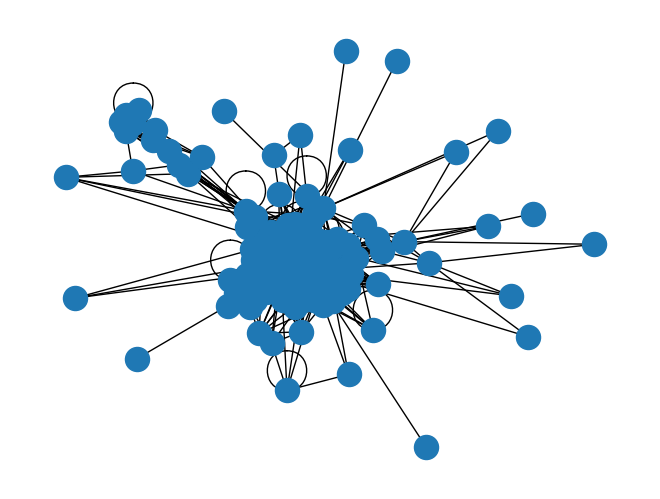

In [23]:
node_count = len(G.nodes())
edge_count = len(G.edges())
print(f"Number of nodes: {node_count}")
print(f"Number of edges: {edge_count}")
nx.draw(G)

# Using `matplotlib`

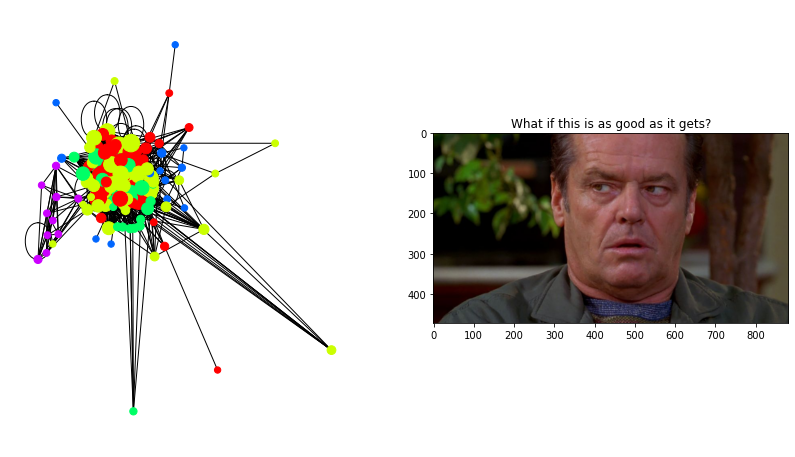

In [24]:
_ = plt2x2(G, "include/images/agaig.jpg")

It's not as good as it gets. We can do better.

# Using `plotly`
## plotly changed something behind the scenes and no longer works
This looks a bit nicer but still not great. My opinion is all Python plotting is at best adequate.

In [30]:
# # Create a plot with the Kamada Kawai algo.  Need to create the nodes and edges.
# pos = nx.kamada_kawai_layout(G)
# edge_trace = go.Scatter(
#     x=[],
#     y=[],
#     line=dict(width=0.5, color="#888"),
#     hoverinfo="none",
#     mode="lines",
# )
# 
# # This takes a bit of time.  Not sure why, yet.
# for edge in G.edges():
#     x0, y0 = pos[edge[0]]
#     x1, y1 = pos[edge[1]]
#     edge_trace["x"] += tuple([x0, x1, None])
#     edge_trace["y"] += tuple([y0, y1, None])

In [31]:
# node_trace = go.Scatter(
#     x=[],
#     y=[],
#     text=[],
#     mode="markers",
#     hoverinfo="text",
#     marker=dict(color=[], size=[]),
# )


# def htext(node: str) -> str:
#     """! Helper function to add html title to nodes."""
#     ret = "<b>" + node + "</b><br>"
#     ret += "    pagerank: " + str(G.nodes()[node]["pagerank"]) + "<br>"
#     ret += "eicentrality: " + str(G.nodes()[node]["eicentrality"]) + "<br>"
#     ret += "   community: " + str(G.nodes()[node]["community"])
#     return ret


# for node in G.nodes():
#     x, y = pos[node]
#     node_trace["x"] += tuple([x])
#     node_trace["y"] += tuple([y])
#     node_trace["marker"]["color"] += tuple([G.nodes()[node]["color"]])
#     node_trace["marker"]["size"] += tuple([G.nodes()[node]["size"]])
#     node_trace["text"] += tuple([htext(node)])


# fig = go.Figure(
#     data=[edge_trace, node_trace],
#     layout=go.Layout(
#         title="Network graph made with Python/plotly",
#         #title=go.layout.Title(text="Network graph made with Python/plotly", font=dict(size=16)),
#         showlegend=False,
#         hovermode="closest",
#         margin=dict(b=20, l=5, r=5, t=40),
#         annotations=[
#             dict(
#                 showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.002
#             )
#         ],
#         xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#         yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#     ),
# )

In [32]:
# py.iplot(fig, filename="plot")

Better, no?  But we can still improve upon this.

# Using `d3`

In [33]:
inject('<div id="d3target"></div>')
inject("#d3target line.links {stroke: grey; opacity: 0.5}", code_type="css")

In [34]:
inject(
    f'drawgraph("#d3target", {json.dumps(nx.node_link_data(G, edges="edges"))}, 1000, 600)',
    code_type="js",
);

# Take-aways

- Graph operations show up in quite a few areas.
- Python has a number of tools to help you out.
- As your graph grows you need to be more judicious in your tool selection.
- Understand your data.
- Visualizing large graphs is difficult. Zelously edit.
- Graphs are a dessert topping and a floor wax.